### In-Medium SRG in the TensorNetwork architecture
This code implements the IM-SRG flow equations in the TensorNetwork architecture. TensorNetwork is an open source library that optimizes tensor network algorithms, using TensorFlow in the backend. The library provides an intuitive interface for writing tensor networks in a graphical representation. See <a href="https://arxiv.org/pdf/1905.01330.pdf">arXiv:1905.01330</a> for an introduction to the library.

TensorNetwork library --> <a href="https://www.github.com/google/TensorNetwork">TensorNetwork Github</a> <br>
TensorFlow library (this code uses core release 1.13.1)--> <a href="https://www.tensorflow.org">TensorFlow website</a> <br>

In [1]:
import numpy as np
from scipy.integrate import odeint, ode
import tensorflow as tf
tf.enable_v2_behavior()
import tensornetwork
from tensornetwork import ncon    
import matplotlib.pyplot as plt
print(tf.__version__)

1.13.1


In [2]:
# --- BUILD HAMILTONIAN -----------

# optional keywords: d    = energy level spacing 
#                    g    = pair interaction coupling strength
#                    pb   = pair breaking interaction strength 

def build_hamiltonian(n_hole_states, n_particle_states, d, g, pb):
    
    def delta2B(p,q,r,s):
        pp = np.floor_divide(p,2)
        qp = np.floor_divide(q,2)
        rp = np.floor_divide(r,2)
        sp = np.floor_divide(s,2)

        ps = 1 if p%2==0 else -1
        qs = 1 if q%2==0 else -1
        rs = 1 if r%2==0 else -1
        ss = 1 if s%2==0 else -1
        
        if pp != qp or rp != sp:
            return 0
        if ps == qs or rs == ss:
            return 0
        if ps == rs and qs == ss:
            return -0.5
        if ps == ss and qs == rs:
            return 0.5
        
        return 0
    
    def deltaPB(p,q,r,s):
        pp = np.floor_divide(p,2)
        qp = np.floor_divide(q,2)
        rp = np.floor_divide(r,2)
        sp = np.floor_divide(s,2)

        ps = 1 if p%2==0 else -1
        qs = 1 if q%2==0 else -1
        rs = 1 if r%2==0 else -1
        ss = 1 if s%2==0 else -1
        
        if (pp != qp and rp == sp) or (pp == qp and rp != sp):
            if ps == qs or rs == ss:
                return 0
            if ps == rs and qs == ss:
                return -0.5
            if ps == ss and qs == rs:
                return 0.5
        
        return 0
    
    numh = n_hole_states
    nump = n_particle_states
    nums = numh + nump
    
    ref = np.append(np.ones(numh), np.zeros(nump))
    holes = np.arange(numh)
    particles = np.arange(numh,numh+nump)
    B1 = np.append(holes,particles)
    
    # one body part of Hamiltonian is floor-division of basis index
    # matrix elements are (P-1) where P is energy level
    H1B = np.diag(d*np.floor_divide(B1,2))

    H2B = np.zeros((nums, nums, nums, nums))
    for p in B1:
        for q in B1:
            for r in B1:
                for s in B1:
                    H2B[p,q,r,s] += g*delta2B(p,q,r,s)
                    H2B[p,q,r,s] += pb*deltaPB(p,q,r,s)
                        
    return (H1B, H2B, ref, holes, particles, B1)


# H1B, H2B, ref, holes, particles, B1 = build_hamiltonian(4,4)  
# print(H2B[4,7,0,1])

In [3]:
# covers na - nb
def get_occA(B1_basis, ref, flag=0):
    if flag == 0: # default
        n = len(B1_basis)
        occA = np.zeros((n,n,n,n))

        for a in B1_basis:
            for b in B1_basis:
                occA[a,b,a,b] = ref[a] - ref[b]

        return occA
    
    if flag == 1:
        n = len(B1_basis)
        occA = np.zeros((n,n))

        for a in B1_basis:
            for b in B1_basis:
                occA[a,b] = ref[a] - ref[b]

        return occA    
        
# covers (1-na-nb)
def get_occB(B1_basis, ref, flag=0):
    if flag == 0: # default
        n = len(B1_basis)    
        occB = np.zeros((n,n,n,n))

        for a in B1_basis:
            for b in B1_basis:
                occB[a,b,a,b] = 1 - ref[a] - ref[b]

        return occB
    
    if flag == 1:
        n = len(B1_basis)    
        occB = np.zeros((n,n))

        for a in B1_basis:
            for b in B1_basis:
                occB[a,b] = 1 - ref[a] - ref[b]

        return occB        
        
# covers na*nb + (1-na-nb)*nc
def get_occC(B1_basis, ref, flag=0):
    if flag == 0: # default
        n = len(B1_basis)        
        occC = np.zeros((n,n,n,n,n,n))

        for a in B1_basis:
            for b in B1_basis:
                for c in B1_basis:
                    occC[a,b,c,a,b,c] = ref[a]*ref[b] + (1-ref[a]-ref[b])*ref[c]

        return occC
    
    if flag == 1:
        n = len(B1_basis)        
        occC = np.zeros((n,n,n))

        for a in B1_basis:
            for b in B1_basis:
                for c in B1_basis:
                    occC[a,b,c] = ref[a]*ref[b] + (1-ref[a]-ref[b])*ref[c]


# covers na*nb*(1-nc-nd) + na*nb*nc*nd
def get_occD(B1_basis, ref, flag=0):
    if flag == 0: # default
        n = len(B1_basis)    
        occD = np.zeros((n,n,n,n,n,n,n,n))

        for a in B1_basis:
            for b in B1_basis:
                for c in B1_basis:
                    for d in B1_basis:
                        occD[a,b,c,d,a,b,c,d] = ref[a]*ref[b]*(1-ref[c]-ref[d])+ref[a]*ref[b]*ref[c]*ref[d]

        return occD
    
    if flag == 1:
        n = len(B1_basis)    
        occD = np.zeros((n,n,n,n))

        for a in B1_basis:
            for b in B1_basis:
                for c in B1_basis:
                    for d in B1_basis:
                        occD[a,b,c,d] = ref[a]*ref[b]*(1-ref[c]-ref[d])+ref[a]*ref[b]*ref[c]*ref[d]

        return occD

def create_network(node_list):
    net = tensornetwork.TensorNetwork()
    assert isinstance(node_list, list), "argument must be a list of nodes"
    
    node_instances = []
    for new_node in node_list:
        node = net.add_node(new_node)
        node_instances.append(node)
        
    return (net, node_instances)

In [4]:
# --- NORMAL ORDER HAMILTONIAN -----------
# Calculate 0b, 1b, 2b pieces 
#
# zero-body piece is scalar
# one-body piece is rank 2 tensor
# two-body piece is rank 4 tensor

def normal_order(H1B_t, H2B_t, holes, particles):
    bas1B = np.append(holes,particles)
    
    net = tensornetwork.TensorNetwork()
    
    # - Calculate 0B piece
    H1B_holes = H1B_t[np.ix_(holes,holes)]
    H2B_holes = H2B_t[np.ix_(holes,holes,holes,holes)]
    
    ob_node0b = net.add_node(H1B_holes)
    tb_node0b = net.add_node(H2B_holes)
    
    ob_ii = net.connect(ob_node0b[0],ob_node0b[1])
    tb_ijij1 = net.connect(tb_node0b[0], tb_node0b[2])
    tb_ijij2 = net.connect(tb_node0b[1], tb_node0b[3])
    
    flatten = net.flatten_edges([tb_ijij1, tb_ijij2])
    ob_contract = net.contract(ob_ii).tensor.numpy()
    tb_contract = 0.5*net.contract(flatten).tensor.numpy()

    E = ob_contract + tb_contract
    
    
    # - Calculate 1B piece
    ob_node1b = net.add_node(H1B_t)
    tb_node1b = net.add_node(H2B_t[np.ix_(bas1B,holes,bas1B,holes)])
    
    tb_ihjh = net.connect(tb_node1b[1], tb_node1b[3])
    tb_contract = net.contract(tb_ihjh)
    
    f = ob_node1b.tensor.numpy() + tb_contract.tensor.numpy()
    
    G = H2B_t
    
    return (E, f, G)

In [5]:
def wegner_tn(f, G, holes, particles, occA, occB, occC, occD):
    bas1B = np.append(holes,particles)
    
#     net = tensornetwork.TensorNetwork()
#     occA_node = net.add_node(occA)
#     occB_node = net.add_node(occB)
#     occC_node = net.add_node(occC)
#     occD_node = net.add_node(occD)
    
    # - Decouple off-diagonal 1B and 2B pieces
    fod = np.zeros(f.shape)
    fod[np.ix_(particles, holes)] += f[np.ix_(particles, holes)]
    fod[np.ix_(holes, particles)] += f[np.ix_(holes, particles)]
    fd = f - fod
    
    God = np.zeros(G.shape)
    God[np.ix_(particles, particles, holes, holes)] += G[np.ix_(particles, particles, holes, holes)]
    God[np.ix_(holes, holes, particles, particles)] += G[np.ix_(holes, holes, particles, particles)]
    Gd = G - God
    
#     fd_node = net.add_node(fd)
#     Gd_node = net.add_node(Gd)
#     fod_node = net.add_node(fod)
#     God_node = net.add_node(God)
    
    # - Calculate 1B piece of generator
    # network for term 1
    net_1b1, nodes = create_network([fd, Gd, fod, God])
    fd_node = nodes[0]
    Gd_node = nodes[1]
    fod_node = nodes[2]
    God_node = nodes[3]
#     print(type(fd_node))
#     sum1 = ncon([fd, fod], [(-1,2), (2,-2)])
    sum1_edge = net_1b1.connect(fd_node[1], fod_node[0], name="eta1b_fdfod_edge")
    sum1_cont = net_1b1.contract(sum1_edge, name="eta1b_fdfod_contract")
    sum1 = sum1_cont.tensor.numpy() - np.transpose(sum1_cont.tensor.numpy())
    
    # network for term 2
    net_1b2, nodes = create_network([fd, Gd, fod, God, occA])
    fd_node = nodes[0]
    Gd_node = nodes[1]
    fod_node = nodes[2]
    God_node = nodes[3]
    occA_node = nodes[4]
    
    sum2_edgeA_fdGod = net_1b2.connect(fd_node[0], God_node[2], name="eta1B_fdGod_edgeA")
    sum2_edgeB_fdGod = net_1b2.connect(fd_node[1], God_node[0], name="eta1B_fdGod_edgeB")
    sum2_edgeA_fodGd = net_1b2.connect(fod_node[0], Gd_node[2], name="eta1B_fodGd_edgeA")
    sum2_edgeB_fodGd = net_1b2.connect(fod_node[1], Gd_node[0], name="eta1B_fodGd_edgeB")
    sum2_edge_fdGod_f = net_1b2.flatten_edges([sum2_edgeA_fdGod, sum2_edgeB_fdGod])
    sum2_edge_fodGd_f = net_1b2.flatten_edges([sum2_edgeA_fodGd, sum2_edgeB_fodGd])
    sum2_cont_fdGod = net_1b2.contract(sum2_edge_fdGod_f, name="eta1B_fdGod_contract")
    sum2_cont_fodGd = net_1b2.contract(sum2_edge_fodGd_f, name="eta1B_fodGd_contract")
#     sum2_edgeA_occA = net_1b2.connect(occA[0], sum2_cont_fdGod[0])
    
    
    return sum1

In [6]:
def wegner_ncon(f, G, holes, particles, occA, occB, occC, occD):
    
    # - Decouple off-diagonal 1B and 2B pieces
    fod = np.zeros(f.shape)
    fod[np.ix_(particles, holes)] += f[np.ix_(particles, holes)]
    fod[np.ix_(holes, particles)] += f[np.ix_(holes, particles)]
    fd = f - fod

    God = np.zeros(G.shape)
    God[np.ix_(particles, particles, holes, holes)] += G[np.ix_(particles, particles, holes, holes)]
    God[np.ix_(holes, holes, particles, particles)] += G[np.ix_(holes, holes, particles, particles)]
    Gd = G - God
    
    
    # - Calculate 1B generator
    # first term
    sum1_1b_1 = ncon([fd, fod], [(-1, 0), (0, -2)]).numpy()
    sum1_1b_2 = np.transpose(sum1_1b_1)
    sum1_1b = sum1_1b_1 - sum1_1b_2
    
    # second term
    sum2_1b_1 = ncon([fd, God], [(0, 1), (1, -1, 0, -2)]).numpy()
    sum2_1b_2 = ncon([fod, Gd], [(0, 1), (1, -1, 0, -2)]).numpy()
    sum2_1b_3 = sum2_1b_1 - sum2_1b_2
    sum2_1b = ncon([occA, sum2_1b_3],[(-1, -2, 0, 1), (0,1)]).numpy()
    
    # third term
    sum3_1b_1 = ncon([occC, God], [(-1, -2, -3, 0, 1, 2), (0, 1, 2, -4)]).numpy()
    sum3_1b_2 = ncon([Gd, sum3_1b_1], [(2, -1, 0, 1), (0, 1, 2, -2)]).numpy()
    sum3_1b_3 = np.transpose(sum3_1b_2)
    sum3_1b = sum3_1b_2 - sum3_1b_3
    
    eta1B = sum1_1b + sum2_1b + 0.5*sum3_1b
    
    
    # - Calculate 2B generator
    # first term (P_ij piece)
    sum1_2b_1 = ncon([fd, God], [(-1, 0), (0, -2, -3, -4)]).numpy()
    sum1_2b_2 = ncon([fod, Gd], [(-1, 0), (0, -2, -3, -4)]).numpy()
    sum1_2b_3 = sum1_2b_1 - sum1_2b_2
    sum1_2b_4 = np.transpose(sum1_2b_3, [1, 0, 2, 3])
    sum1_2b_5 = sum1_2b_3 - sum1_2b_4
    
    # first term (P_kl piece)
    sum1_2b_6 = ncon([fd, God], [(0, -3), (-1, -2, 0, -4)]).numpy()
    sum1_2b_7 = ncon([fod, Gd], [(0, -3), (-1, -2, 0, -4)]).numpy()
    sum1_2b_8 = sum1_2b_6 - sum1_2b_7
    sum1_2b_9 = np.transpose(sum1_2b_8, [0, 1, 3, 2])
    sum1_2b_10 = sum1_2b_8 - sum1_2b_9
    
    sum1_2b = sum1_2b_5 - sum1_2b_10

    # second term
    sum2_2b_1 = ncon([occB, God], [(-1, -2, 0, 1), (0, 1, -3, -4)]).numpy()
    sum2_2b_2 = ncon([occB,  Gd], [(-1, -2, 0, 1), (0, 1, -3, -4)]).numpy()
    sum2_2b_3 = ncon([Gd,  sum2_2b_1], [(-1, -2, 0, 1), (0, 1, -3, -4)]).numpy()
    sum2_2b_4 = ncon([God, sum2_2b_2], [(-1, -2, 0, 1), (0, 1, -3, -4)]).numpy()
    sum2_2b = sum2_2b_3 - sum2_2b_4

    # third term
    sum3_2b_1 = ncon([Gd, God], [(0, -1, 1, -3), (1, -2, 0, -4)]).numpy()
    sum3_2b_2 = np.transpose(sum3_2b_1, [1, 0, 2, 3])
    sum3_2b_3 = np.transpose(sum3_2b_1, [0, 1, 3, 2])
    sum3_2b_4 = np.transpose(sum3_2b_1, [1, 0, 3, 2])
    sum3_2b_5 = sum3_2b_1 - sum3_2b_2 - sum3_2b_3 + sum3_2b_4
    sum3_2b = ncon([occA, sum3_2b_5], [(0, 1, -1, -2), (0, 1, -3, -4)]).numpy()

    eta2B = sum1_2b + 0.5*sum2_2b + sum3_2b
    
    return (eta1B, eta2B)

In [7]:
def flow(f, G, eta1B, eta2B, holes, particles, occA, occB, occC, occD):
    
    # - Calculate dE/ds
    # first term
    sum1_0b_1 = ncon([occA, eta1B], [(0, 1, -1, -2), (0, 1)]).numpy()
    sum1_0b = ncon([sum1_0b_1, f], [(0, 1), (1, 0)]).numpy()
    
    # second term
    sum2_0b_1 = np.matmul(eta2B, occD)
    sum2_0b = ncon([sum2_0b_1, G], [(0, 1, 2, 3), (2, 3, 0, 1)]).numpy()
    
    dE = sum1_0b + 0.5*sum2_0b
    
    
    # - Calculate df/ds
    # first term
    sum1_1b_1 = ncon([eta1B, f], [(-1, 0), (0, -2)]).numpy()
    sum1_1b_2 = np.transpose(sum1_1b_1)
    sum1_1b = sum1_1b_1 + sum1_1b_2
    
    # second term (might need to fix)
    sum2_1b_1 = ncon([eta1B, G], [(0, 1), (1, -1, 0, -2)]).numpy()
    sum2_1b_2 = ncon([f, eta2B], [(0, 1), (1, -1, 0, -2)]).numpy()
    sum2_1b_3 = sum2_1b_1 - sum2_1b_2
    sum2_1b = ncon([occA, sum2_1b_3],[(-1, -2, 0, 1), (0,1)]).numpy()
    
    # third term
    sum3_1b_1 = ncon([occC, G], [(-1, -2, -3, 0, 1, 2), (0, 1, 2, -4)]).numpy()
    sum3_1b_2 = ncon([eta2B, sum3_1b_1], [(2, -1, 0, 1), (0, 1, 2, -2)]).numpy()
    sum3_1b_3 = np.transpose(sum3_1b_2)
    sum3_1b = sum3_1b_2 + sum3_1b_3
    
    df = sum1_1b + sum2_1b + 0.5*sum3_1b
    
    
    # - Calculate dG/ds
    # first term (P_ij piece)
    sum1_2b_1 = ncon([eta1B, G], [(-1, 0), (0, -2, -3, -4)]).numpy()
    sum1_2b_2 = ncon([f, eta2B], [(-1, 0), (0, -2, -3, -4)]).numpy()
    sum1_2b_3 = sum1_2b_1 - sum1_2b_2
    sum1_2b_4 = np.transpose(sum1_2b_3, [1, 0, 2, 3])
    sum1_2b_5 = sum1_2b_3 - sum1_2b_4
    
    # first term (P_kl piece)
    sum1_2b_6 = ncon([eta1B, G], [(0, -3), (-1, -2, 0, -4)]).numpy()
    sum1_2b_7 = ncon([f, eta2B], [(0, -3), (-1, -2, 0, -4)]).numpy()
    sum1_2b_8 = sum1_2b_6 - sum1_2b_7
    sum1_2b_9 = np.transpose(sum1_2b_8, [0, 1, 3, 2])
    sum1_2b_10 = sum1_2b_8 - sum1_2b_9
    
    sum1_2b = sum1_2b_5 - sum1_2b_10

    # second term
    sum2_2b_1 = ncon([occB,     G], [(-1, -2, 0, 1), (0, 1, -3, -4)]).numpy()
    sum2_2b_2 = ncon([occB, eta2B], [(-1, -2, 0, 1), (0, 1, -3, -4)]).numpy()
    sum2_2b_3 = ncon([eta2B,  sum2_2b_1], [(-1, -2, 0, 1), (0, 1, -3, -4)]).numpy()
    sum2_2b_4 = ncon([G,      sum2_2b_2], [(-1, -2, 0, 1), (0, 1, -3, -4)]).numpy()
    sum2_2b = sum2_2b_3 - sum2_2b_4

    # third term
    sum3_2b_1 = ncon([eta2B, G], [(0, -1, 1, -3), (1, -2, 0, -4)]).numpy()
    sum3_2b_2 = np.transpose(sum3_2b_1, [1, 0, 2, 3])
    sum3_2b_3 = np.transpose(sum3_2b_1, [0, 1, 3, 2])
    sum3_2b_4 = np.transpose(sum3_2b_1, [1, 0, 3, 2])
    sum3_2b_5 = sum3_2b_1 - sum3_2b_2 - sum3_2b_3 + sum3_2b_4
    sum3_2b = ncon([occA, sum3_2b_5], [(0, 1, -1, -2), (0, 1, -3, -4)]).numpy()

    dG = sum1_2b + 0.5*sum2_2b + sum3_2b    
    
    return (dE, df, dG)

In [8]:

def derivative(t, y, holes, particles, occA, occB, occC, occD):
    
    E, f, G = ravel(y, holes, particles)

    eta1B, eta2B = wegner_ncon(f, G, holes, particles, occA, occB, occC, occD)
    
    dE, df, dG = flow(f, G, eta1B, eta2B, holes, particles, occA, occB, occC, occD)
    
    dy = unravel(dE, df, dG)
    
    return dy

In [9]:
def unravel(E, f, G):
    unravel_E = np.reshape(E, -1)
    unravel_f = np.reshape(f, -1)
    unravel_G = np.reshape(G, -1)
    
    return np.concatenate([unravel_E, unravel_f, unravel_G], axis=0)

def ravel(y, holes, particles):
    
    bas_len = len(np.append(holes,particles))
    
    ravel_E = np.reshape(y[0], ())
    ravel_f = np.reshape(y[1:bas_len**2+1], (bas_len, bas_len))
    ravel_G = np.reshape(y[bas_len**2+1:bas_len**2+1+bas_len**4], 
                         (bas_len, bas_len, bas_len, bas_len))
    
    return(ravel_E, ravel_f, ravel_G)

In [10]:

def main(n_holes, n_particles, d=1, g=0.5, pb=0):
    
    print("""Pairing model IM-SRG flow: 
    d              = {:2d}
    g              = {:2.4f}
    pb             = {:2.4f}
    SP basis size  = {:2d}
    n_holes        = {:2d}
    n_particles    = {:2d}""".format(d, g, pb,n_holes+n_particles,n_holes,n_particles))
    
    print("Flowing...")
    
    H1B, H2B, ref, holes, particles, B1 = build_hamiltonian(n_holes, n_particles, d, g, pb)
    E, f, G = normal_order(H1B, H2B, holes, particles)

    occA = get_occA(B1, ref)
    occB = get_occB(B1, ref)
    occC = get_occC(B1, ref)
    occD = get_occD(B1, ref, 1)

    # --- Solve the IM-SRG flow
    y0 = unravel(E, f, G)

    solver = ode(derivative,jac=None)
    solver.set_integrator('vode', method='bdf', order=5, nsteps=1000)
    solver.set_f_params(holes, particles, occA, occB, occC, occD)
    solver.set_initial_value(y0, 0.)

    sfinal = 50
    ds = 0.1
    s_vals = []
    E_vals = []

    iters = 0
    convergence = 0
    while solver.successful() and solver.t < sfinal:

        ys = solver.integrate(sfinal, step=True)
        Es, fs, Gs = ravel(ys, holes, particles) 
        s_vals.append(solver.t)
        E_vals.append(Es)

        iters += 1

#         if iters %10 == 0: print("iter: {:>6d} \t scale param: {:0.4f} \t E = {:0.9f}".format(iters, solver.t, Es))

        if len(E_vals) > 20 and abs(E_vals[-1] - E_vals[-2]) < 10**-8:
            print("---- Energy converged at iter {:>06d} with energy {:1.8f}\n".format(iters,E_vals[-1]))
            convergence = 1
            break

        if len(E_vals) > 20 and abs(E_vals[-1] - E_vals[-2]) > 1:
            print("---- Energy diverged at iter {:>06d} with energy {:3.8f}\n".format(iters,E_vals[-1]))
            break
    
    return (convergence, iters, d, g, pb, n_holes+n_particles, s_vals, E_vals)

In [12]:
start = 0.0001
stop = 1

gsv = np.linspace(start, stop)
pbs = np.linspace(start, stop)

data_container = np.array([])
for g in gsv:
    pb_list = np.array([])
    for pb in pbs:
        data = main(4,4, g=g, pb=pb) # (convergence, s_vals, E_vals)
        pb_list = np.append(pb_list, data)
        if data[0] == 0:
            print("divergence reached; continuing to next g value")
            break
    data_container = np.append(data_container, pb_list)
    
import pickle
with open('data.pickle', 'wb') as f:
    pickle.dump(data_container, f, pickle.HIGHEST_PROTOCOL)
print("convergence data written to data.pickle")

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.0001
    pb             = 0.0001
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000021 with energy 1.99989999

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.0001
    pb             = 0.0205
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000258 with energy 1.99918932

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.0001
    pb             = 0.0409
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000769 with energy 1.99706489

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.0001
    pb             = 0.0613
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000901 with energy 1.99

---- Energy converged at iter 001030 with energy 1.91465269

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.0817
    pb             = 0.0409
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000882 with energy 1.91162283

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.0817
    pb             = 0.0613
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000680 with energy 1.90717257

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.0817
    pb             = 0.0817
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000615 with energy 1.90122083

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.0817
    pb             = 0.1021
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 000975 with energy 1.82187873

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.1633
    pb             = 0.0613
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000754 with energy 1.81647625

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.1633
    pb             = 0.0817
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000572 with energy 1.80961050

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.1633
    pb             = 0.1021
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000526 with energy 1.80117520

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.1633
    pb             = 0.1225
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 000507 with energy 1.70385787

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.2450
    pb             = 0.1225
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000448 with energy 1.69285426

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.2450
    pb             = 0.1429
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy diverged at iter 001571 with energy -17.40938182

divergence reached; continuing to next g value
Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.2654
    pb             = 0.0001
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000147 with energy 1.71242040

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.2654
    pb             = 0.0205
    SP basis size  =  8
   

---- Energy converged at iter 000536 with energy 1.58939420

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.3266
    pb             = 0.1429
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy diverged at iter 002466 with energy 38.09187618

divergence reached; continuing to next g value
Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.3470
    pb             = 0.0001
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000152 with energy 1.61411994

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.3470
    pb             = 0.0205
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000886 with energy 1.60918454

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.3470
    pb             = 0.0409
    SP basis size  =  8
    

divergence reached; continuing to next g value
Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.4490
    pb             = 0.0001
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000162 with energy 1.48387515

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.4490
    pb             = 0.0205
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000733 with energy 1.47753976

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.4490
    pb             = 0.0409
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000980 with energy 1.46963321

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.4490
    pb             = 0.0613
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- E

---- Energy converged at iter 000170 with energy 1.37332840

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.5307
    pb             = 0.0205
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000635 with energy 1.36582739

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.5307
    pb             = 0.0409
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000836 with energy 1.35669967

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.5307
    pb             = 0.0613
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001024 with energy 1.34610055

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.5307
    pb             = 0.0817
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 000911 with energy 1.25643517

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.5919
    pb             = 0.0817
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000962 with energy 1.24352936

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.5919
    pb             = 0.1021
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001232 with energy 1.22931757

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.5919
    pb             = 0.1225
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001456 with energy 1.21381947

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.5919
    pb             = 0.1429
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 000171 with energy 1.19601382

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.6531
    pb             = 0.0205
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000551 with energy 1.18668259

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.6531
    pb             = 0.0409
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000657 with energy 1.17563203

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.6531
    pb             = 0.0613
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000779 with energy 1.16311613

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.6531
    pb             = 0.0817
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 001017 with energy 1.05221550

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.6939
    pb             = 0.1429
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001147 with energy 1.03466613

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.6939
    pb             = 0.1633
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001296 with energy 1.01619647

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.6939
    pb             = 0.1838
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001492 with energy 0.99682867

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.6939
    pb             = 0.2042
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 001250 with energy 0.92885090

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.7347
    pb             = 0.2042
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001454 with energy 0.90884261

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.7347
    pb             = 0.2246
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001681 with energy 0.88813049

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.7347
    pb             = 0.2450
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001969 with energy 0.86667659

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.7347
    pb             = 0.2654
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 001073 with energy 0.85917157

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.7755
    pb             = 0.2042
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001221 with energy 0.83943140

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.7755
    pb             = 0.2246
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001382 with energy 0.81918496

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.7755
    pb             = 0.2450
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001638 with energy 0.79841529

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.7755
    pb             = 0.2654
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 000742 with energy 0.82563693

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8163
    pb             = 0.1633
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000818 with energy 0.80689111

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8163
    pb             = 0.1838
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000849 with energy 0.78777959

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8163
    pb             = 0.2042
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000970 with energy 0.76833881

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8163
    pb             = 0.2246
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 000510 with energy 0.83927254

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8572
    pb             = 0.0613
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000562 with energy 0.82346127

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8572
    pb             = 0.0817
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000547 with energy 0.80661590

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8572
    pb             = 0.1021
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000622 with energy 0.78901707

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8572
    pb             = 0.1225
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 001516 with energy 0.56259178

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8776
    pb             = 0.3266
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001811 with energy 0.54270452

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8776
    pb             = 0.3470
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 002274 with energy 0.52237069

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8776
    pb             = 0.3674
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 003095 with energy 0.50141600

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.8776
    pb             = 0.3878
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 000617 with energy 0.63901074

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9184
    pb             = 0.1633
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000612 with energy 0.62030699

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9184
    pb             = 0.1838
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000686 with energy 0.60170096

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9184
    pb             = 0.2042
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000662 with energy 0.58322926

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9184
    pb             = 0.2246
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 000983 with energy 0.47380543

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9388
    pb             = 0.3062
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001166 with energy 0.45613990

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9388
    pb             = 0.3266
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001263 with energy 0.43833849

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9388
    pb             = 0.3470
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 001509 with energy 0.42030050

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9388
    pb             = 0.3674
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 000734 with energy 0.31288208

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9592
    pb             = 0.4490
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000420 with energy 0.29298488

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9592
    pb             = 0.4694
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000439 with energy 0.27230893

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9592
    pb             = 0.4898
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000434 with energy 0.25065839

Pairing model IM-SRG flow: 
    d              =  1
    g              = 0.9592
    pb             = 0.5103
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

---- Energy converged at iter 000178 with energy 0.60652934

Pairing model IM-SRG flow: 
    d              =  1
    g              = 1.0000
    pb             = 0.0205
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000398 with energy 0.59164528

Pairing model IM-SRG flow: 
    d              =  1
    g              = 1.0000
    pb             = 0.0409
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000439 with energy 0.57487951

Pairing model IM-SRG flow: 
    d              =  1
    g              = 1.0000
    pb             = 0.0613
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flowing...
---- Energy converged at iter 000448 with energy 0.55686431

Pairing model IM-SRG flow: 
    d              =  1
    g              = 1.0000
    pb             = 0.0817
    SP basis size  =  8
    n_holes        =  4
    n_particles    =  4
Flo

<class 'numpy.ndarray'>
(4936,)


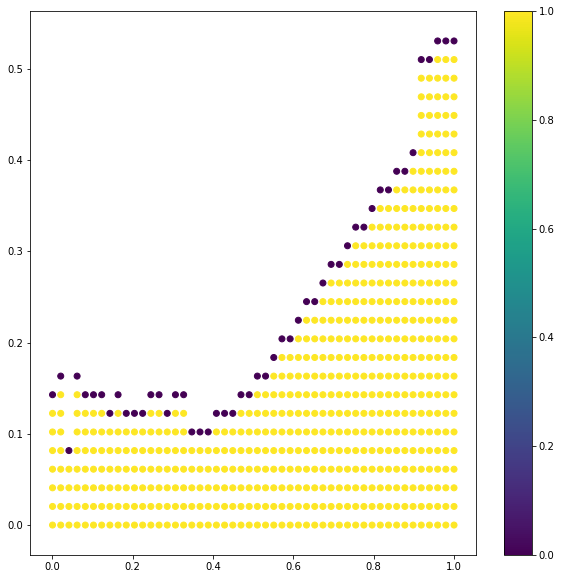

In [32]:
with open('data.pickle', 'rb') as f:
    container = pickle.load(f)
    
print(type(container))
print(container.shape)
container = np.reshape(container, (617,8))

figure = plt.figure(figsize=[10,10])
g_vals = container[:,3]
pb_vals = container[:,4]
con_vals = container[:,0]

plt.scatter(g_vals,pb_vals,c=con_vals)
plt.colorbar()
# convergence, iters, d, g, pb, sp_states, s_vals, E_vals = final_test
# plt.plot(s_vals, E_vals)


# plt.legend(pbs)
# plt.title("Energy convergence")
# plt.xlabel("s")
# plt.ylabel("E")
# plt.ylim([-0.1, 1.5])
# plt.savefig('convergence.jpg')
# plt.show()